In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
#Importing the required libs, GridSearchCV and train_test_split deprecated

In [12]:
FILE_PATH_SummarizedListings = "/Users/xynazog/FML/listings_NYC.csv"

In [13]:
FILE_PATH_DetailedListings = "/Users/xynazog/FML/NYC_Detailed_Listings.csv"

In [16]:
cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating'
        ]

In [17]:
df = pd.read_csv(FILE_PATH_DetailedListings, usecols = cols)

  neighbourhood_cleansed        room_type  accommodates  bedrooms  beds  \
0       Ditmars Steinway  Entire home/apt             2       0.0   1.0   
1            City Island     Private room             2       1.0   1.0   
2            City Island  Entire home/apt             3       1.0   1.0   
3            City Island  Entire home/apt             4       1.0   3.0   
4            City Island  Entire home/apt             4       3.0   3.0   

     price  availability_30  number_of_reviews  review_scores_rating  \
0  $110.00                0                  0                   NaN   
1   $50.00               19                  2                 100.0   
2  $125.00               28                 21                  95.0   
3  $100.00               30                  0                   NaN   
4  $300.00               30                  0                   NaN   

  instant_bookable cancellation_policy  reviews_per_month  
0                f              strict                Na

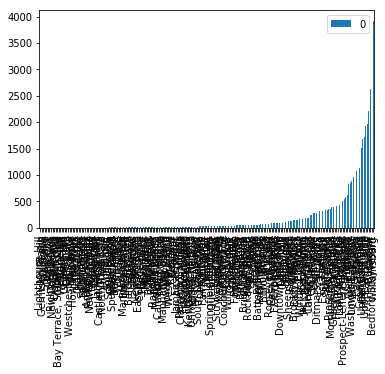

In [24]:
#Checking the first few rows of the read df
print (df.head())
nb_counts = Counter(df.neighbourhood_cleansed)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

In [32]:
print (df['reviews_per_month'].head())
df['reviews_per_month'].fillna(0, inplace = True)
print (df['reviews_per_month'].head())

0    0.00
1    2.00
2    0.77
3    0.00
4    0.00
Name: reviews_per_month, dtype: float64
0    0.00
1    2.00
2    0.77
3    0.00
4    0.00
Name: reviews_per_month, dtype: float64


In [34]:
#Remove unusual stuff
df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0)

In [36]:
#Cleaning the price column, removing $ and making it a float
df = df[df.bedrooms == 1]
df['price'] = df['price'].replace('[\$,)]','',regex=True).replace('[(]','-', regex=True).astype(float) 

In [38]:
#One hot encoding
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)
xcl_dummies = pd.get_dummies(df.cancellation_policy)

In [40]:
# convert boolean column to a single boolean value indicating whether this listing has instant booking available
ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)

In [42]:
# replace the old columns with our new one-hot encoded ones
alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


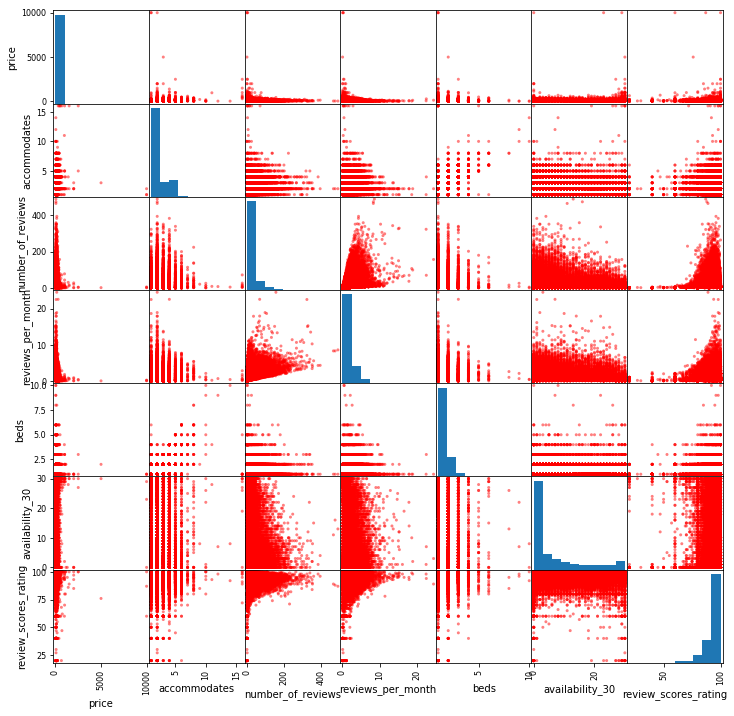

In [48]:
scattercols = ['price','accommodates', 'number_of_reviews', 'reviews_per_month', 'beds', 'availability_30', 'review_scores_rating']
axs = pd.scatter_matrix(alldata[scattercols], figsize=(12, 12), c='red')

In [62]:
#vanilla linear regression, 
#ridge regression,
#lasso regression, 
#ElasticNet, 
#bayesian ridge
#Orthogonal Matching Pursuit.
rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['price'], axis=1),
                                                    alldata.price, test_size=0.2, random_state=20)

In [64]:
for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

Text(0,0.5,'Median Absolute Error')

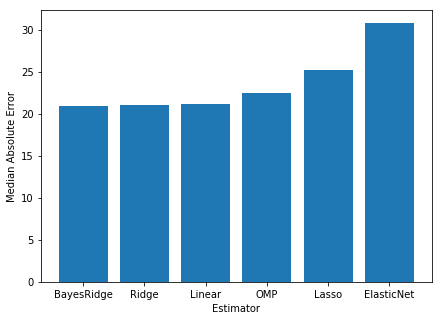

In [66]:
pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

In [82]:
n_est = 500

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1.0 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()

In [83]:
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='median_absolute_error')

In [84]:
preds = clf.fit(X_train, y_train)

/usr/local/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.6

In [86]:
best = clf.best_estimator_

In [93]:
abs(clf.best_score_)

22.071688705237346

Text(0,0.5,'Least Absolute Deviation')

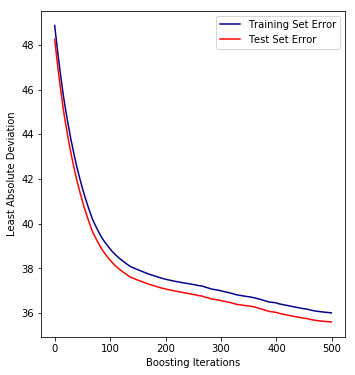

In [88]:
test_score = np.zeros(n_est, dtype=np.float64)
train_score = best.train_score_
#print (train_score)
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')    

Text(0.5,1,'Variable Importance')

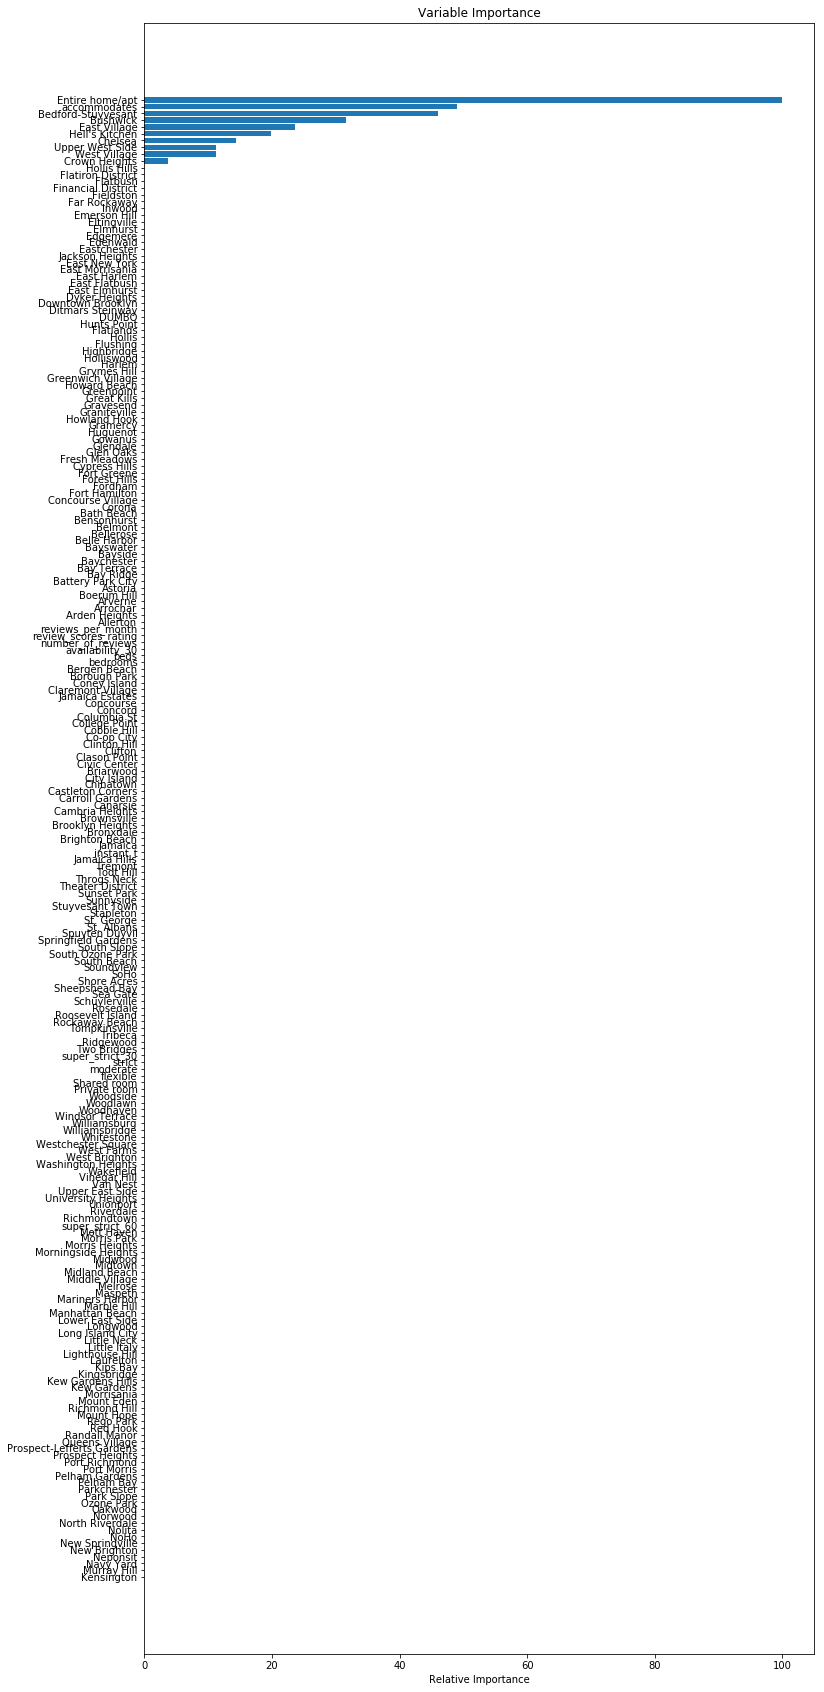

In [92]:
feature_importance = clf.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(12,30))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')